In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from sklearn.ensemble import RandomForestRegressor
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data
import tools

In [2]:
#行业轮动

In [3]:
#获取行业分类
industrys = DP.get_all_industrys()

In [333]:
#industrys
#industry = list(DP.get_industrys('L1').keys())
industry = ['801010.SI',
            '801080.SI',
            '801120.SI',
            '801730.SI',
            '801740.SI',
            '801750.SI',
            '801760.SI',
            '801770.SI',]
#industry = DP.get_industrys('L2')
#取行业内股票数据
data = DP.get_index_data(industrys=industrys, industry=industry)

#money_dic = get_stock_money_data(industry)

In [334]:
#因子构造
OPEN = np.log(data['open'])
HIGH = np.log(data['high'])
LOW = np.log(data['low'])
CLOSE = np.log(data['close'])
vwap = np.log(data['vwap'])
trf = data['trf']
ltrf = np.log(trf)


In [335]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [336]:
n = 2
#y = standardize_industry(OPEN.shift(-n)-OPEN, industrys, industry)
y = standardize(CLOSE.shift(-n+1)-OPEN)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [337]:
r1 = standardize(ror)
r2 = standardize(ror.rolling(3).sum())
r3 = standardize(ror.rolling(5).sum())
r4 = standardize(ror.rolling(10).sum())
r5 = standardize(ror.rolling(15).sum())

x1 = standardize(r_rinei)
x2 = standardize(r_rinei.rolling(3).sum())
x3 = standardize(r_rinei.rolling(5).sum())
x4 = standardize(r_rinei.rolling(10).sum())
x5 = standardize(r_rinei.rolling(15).sum())

z1 = standardize(r_geye)
z2 = standardize(r_geye.rolling(3).sum())
z3 = standardize(r_geye.rolling(5).sum())
z4 = standardize(r_geye.rolling(10).sum())
z5 = standardize(r_geye.rolling(15).sum())

m1 = standardize(np.exp(CLOSE)/np.exp(CLOSE).rolling(3).mean())
m2 = standardize(np.exp(CLOSE)/np.exp(CLOSE).rolling(5).mean())
m3 = standardize(np.exp(CLOSE)/np.exp(CLOSE).rolling(10).mean())
m4 = standardize(np.exp(CLOSE)/np.exp(CLOSE).rolling(15).mean())
m5 = standardize(np.exp(CLOSE)/np.exp(CLOSE).rolling(20).mean())

h1 = standardize(rh)
h2 = standardize(rh.rolling(3).sum())
h3 = standardize(rh.rolling(5).sum())
h4 = standardize(rh.rolling(10).sum())
h5 = standardize(rh.rolling(15).sum())

l1 = standardize(rl)
l2 = standardize(rl.rolling(3).sum())
l3 = standardize(rl.rolling(5).sum())
l4 = standardize(rl.rolling(10).sum())
l5 = standardize(rl.rolling(15).sum())

hl1 = standardize(hl)
hl2 = standardize(hl.rolling(3).sum())
hl3 = standardize(hl.rolling(5).sum())
hl4 = standardize(hl.rolling(10).sum())
hl5 = standardize(hl.rolling(15).sum())

vr1 = standardize(vr)
vr2 = standardize(vr.rolling(3).sum())
vr3 = standardize(vr.rolling(5).sum())
vr4 = standardize(vr.rolling(10).sum())
vr5 = standardize(vr.rolling(15).sum())

rv1 = standardize((ror*vr).abs() * np.sign(ror))
rv2 = standardize((ror.rolling(3).sum()*vr.rolling(3).sum()).abs() * np.sign(ror.rolling(3).sum()))
rv3 = standardize((ror.rolling(5).sum()*vr.rolling(5).sum()).abs() * np.sign(ror.rolling(5).sum()))
rv4 = standardize((ror.rolling(10).sum()*vr.rolling(10).sum()).abs() * np.sign(ror.rolling(10).sum()))
rv5 = standardize((ror.rolling(15).sum()*vr.rolling(15).sum()).abs() * np.sign(ror.rolling(15).sum()))


ao = standardize(vwap-OPEN)
ca = standardize(CLOSE-vwap)

In [338]:
"""n_zhichengzuli = 5
HH = HIGH.rolling(n_zhichengzuli).max()
LL = LOW.rolling(n_zhichengzuli).min()
w = (CLOSE - LL) / (HH - LL)
w = standardize(w)
w.fillna(0, inplace=True)"""

w1 = standardize((CLOSE - LOW.rolling(5).min()) / (HIGH.rolling(5).max() - LOW.rolling(5).min())).fillna(0)
w2 = standardize((CLOSE - LOW.rolling(10).min()) / (HIGH.rolling(10).max() - LOW.rolling(10).min())).fillna(0)
w3 = standardize((CLOSE - LOW.rolling(20).min()) / (HIGH.rolling(20).max() - LOW.rolling(20).min())).fillna(0)
w4 = standardize((CLOSE - LOW.rolling(40).min()) / (HIGH.rolling(40).max() - LOW.rolling(40).min())).fillna(0)
w5 = standardize((CLOSE - LOW.rolling(60).min()) / (HIGH.rolling(60).max() - LOW.rolling(60).min())).fillna(0)

In [339]:
r_market = ror.mean(1)
#回归天数
n_reg = 60
tmp = {k:r_market for k in ror.columns}
'''
tmp = [{k:ror.loc[:, industrys[i]].mean(1) for k in industrys[i]} for i in industry]
tmp1 = {}
for d in tmp:
    tmp1.update(d)
'''
def reg(y, x, n):
    lxx = (x**2).rolling(n).sum() - n * (x.rolling(n).mean()**2)
    lxy = (x * y).rolling(n).sum() - n * x.rolling(n).mean() * y.rolling(n).mean()
    b = lxy / lxx
    a = y.rolling(n).mean() - b * x.rolling(n).mean()
    
    return a, b

a, b = reg(DataFrame(ror), DataFrame(tmp), n_reg)
e = DataFrame(ror) - a - b * DataFrame(tmp)

a = standardize(a)
b = standardize(b)
std_e = standardize(e.rolling(n_reg).std())

sk = a.rolling(n_reg).skew()
ku = a.rolling(n_reg).kurt()
sk = standardize(sk)
ku = standardize(ku)
#b = (n_reg * ror.rolling(n_reg).mean().mul(r_market.rolling(n_reg).mean(), 0) - (ror.mul(r_market, 0)).rolling(n_reg).sum()) / (n_reg * ror.rolling(n_reg).mean()**2 - (ror**2).rolling(n_reg).sum())
#a = (-b * ror.rolling(n_reg).mean()).add(r_market.rolling(n_reg).mean(), 0)

In [340]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rv1':rv1, 'rv2':rv2, 'rv3':rv3, 'rv4':rv4, 'rv5':rv5,
    'ao':ao, 'ca':ca,
    'a':a, 'b':b, 'std_e':std_e,
    'w1':w1, 'w2':w2, 'w3':w3, 'w4':w4, 'w5':w5, 
    'sk':sk, 'ku':ku,
}

In [405]:
factor = {
    'x5':x5,
    'z1':z1,
    'm5':m5,
    'h1':h1,
    'l1':l1,
    'ca':ca,
    'a':a, 'b':b, 'std_e':std_e,
    'w5':w5, 
    'sk':sk, 'ku':ku,
}

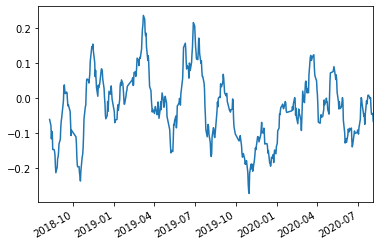

In [341]:
ic, ir = tools.icir(ku.shift().iloc[-500:,:], y.iloc[-500:,:], n=20, rank=True)
ic.rolling(20).mean().plot()
#statsmodels.graphics.tsaplots.plot_acf(ic)

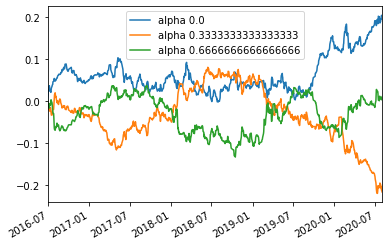

In [347]:
tools.group_backtest((ku).shift().iloc[-1000:,:], ((CLOSE.shift(-n+1)-OPEN) / n).iloc[-1000:,:], n=3)

In [414]:
begin_date = '2012-01-01'
split_date = '2018-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [415]:
df_y_train = DataFrame({'y':y.loc[train_date, :].fillna(0).values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].fillna(0).values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [390]:
df_x_train.loc[:,['x3', 'z3', 'w5', 'm5', 'b', 'std_e']].corr()

,x3,z3,w5,m5,b,std_e
x3,1.000000,-0.304196,0.399371,0.557199,-0.011266,-0.087998
z3,-0.304196,1.000000,0.022952,0.149739,-0.212645,-0.074196
w5,0.399371,0.022952,1.000000,0.645741,-0.255247,-0.199592
m5,0.557199,0.149739,0.645741,1.000000,-0.231635,-0.202403
b,-0.011266,-0.212645,-0.255247,-0.231635,1.000000,0.469720
std_e,-0.087998,-0.074196,-0.199592,-0.202403,0.469720,1.000000


In [416]:
model = RandomForestRegressor(n_estimators=50).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])

In [ ]:
model.

801750.SI    0.602119
801080.SI    0.455327
801760.SI    0.445114
801770.SI    0.338129
801730.SI    0.094820
801740.SI    0.085069
801010.SI   -0.296739
801120.SI   -1.321005
Name: 2017-12-29 00:00:00, dtype: float64


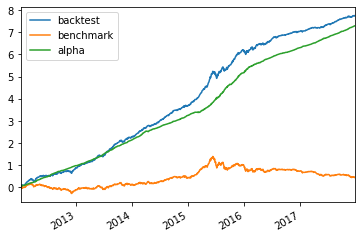

In [441]:
#调仓周期
y_hat = DataFrame(model.predict(df_train.iloc[:, 1:]).reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.7
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

801750.SI    0.553931
801770.SI    0.469461
801120.SI    0.272746
801730.SI    0.188513
801760.SI    0.079314
801080.SI    0.017502
801010.SI   -0.063920
801740.SI   -0.690833
Name: 2020-08-04 00:00:00, dtype: float64


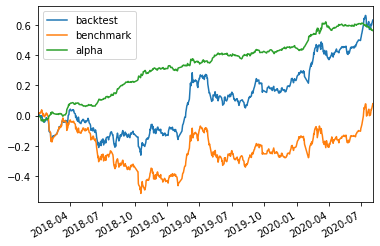

In [442]:
#调仓周期
y_hat = DataFrame(model.predict(df_test.iloc[:, 1:]).reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q = 0.7
position = (y_hat.gt(y_hat.quantile(q1, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [396]:
model = smf.ols('y~\
                  +x5\
                  +z5\
                  +w5\
                  +m5\
                  +b\
                  \
                  ', data=df_train).fit()
model.tvalues

Intercept   -2.863686e-15
x5           3.639880e+00
z5          -2.954904e+00
w5           3.257304e+00
m5          -2.186715e+00
b           -3.807938e+00
dtype: float64

801770.SI    0.131153
801760.SI    0.117427
801120.SI    0.014954
801010.SI   -0.015638
801730.SI   -0.022968
801080.SI   -0.031537
801750.SI   -0.074201
801740.SI   -0.119190
Name: 2018-12-28 00:00:00, dtype: float64


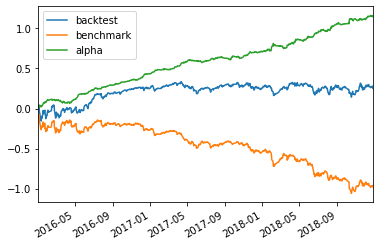

In [397]:
#调仓周期
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.7
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

801120.SI    0.211260
801010.SI    0.131076
801760.SI    0.096198
801080.SI    0.018894
801740.SI    0.000778
801730.SI   -0.009817
801750.SI   -0.211387
801770.SI   -0.237002
Name: 2020-08-04 00:00:00, dtype: float64


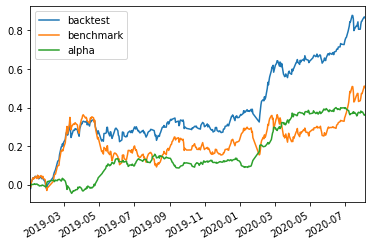

In [398]:
#调仓周期
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q1 = 0.7
position = (y_hat.gt(y_hat.quantile(q1, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

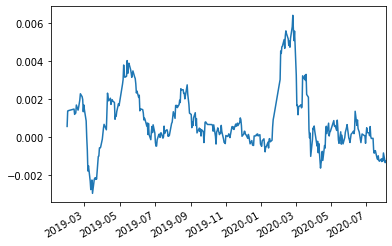

In [57]:
alpha.rolling(20).mean().plot()

In [58]:
position.sum(1)

2019-01-02    0
2019-01-03    4
2019-01-04    4
2019-01-07    4
2019-01-08    4
             ..
2020-07-29    4
2020-07-30    4
2020-07-31    4
2020-08-03    4
2020-08-04    4
Length: 386, dtype: int64

In [41]:
alpha.mean() / alpha.std() * np.sqrt(len(ror_huice))

2.399999274794106

In [42]:
y_hat

,801010.SI,801080.SI,801120.SI,801150.SI,801730.SI,801740.SI,801750.SI,801760.SI,801770.SI
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.127964,-0.006696,-0.168046,-0.183848,0.125121,-0.005687,-0.050061,0.053311,0.107942
2019-01-04,-0.006777,-0.001798,-0.087245,-0.110636,0.152892,0.068036,0.012034,-0.139967,0.113461
2019-01-07,0.071210,-0.077481,-0.065061,-0.143958,0.176715,-0.133547,-0.003336,0.103697,0.071761
2019-01-08,0.088198,0.179470,-0.056400,-0.043073,0.089677,-0.017627,0.055194,-0.348301,0.052862
...,...,...,...,...,...,...,...,...,...
2020-07-29,0.104077,-0.003612,0.037425,-0.063147,-0.005424,0.053351,-0.110488,0.088723,-0.100904
2020-07-30,0.045885,0.090317,-0.321638,0.153434,0.089715,-0.038019,0.041301,-0.002329,-0.058666
2020-07-31,0.131477,0.059882,0.058654,0.046852,0.013075,-0.257309,-0.048817,0.086042,-0.089857
2020-08-03,0.116970,0.079188,-0.177891,0.109986,0.152393,-0.216208,0.013303,0.039174,-0.116915


In [48]:
y_hat.apply(lambda x:Series(sorted(range(len(x)), key = x.__getitem__), index=y_hat.columns), 1).loc[:, ['801750.SI']].to_csv('./a.csv')

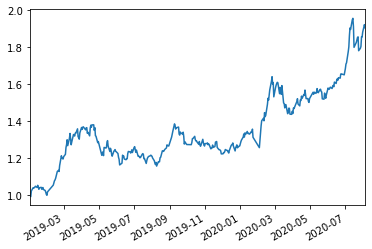

In [76]:
(ror_huice.mean(1)-0.0007+1).cumprod().plot()

In [75]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].fillna(0).values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

801730.SI    0.121319
801010.SI    0.068574
801150.SI    0.066033
801120.SI    0.055799
801080.SI   -0.028375
801770.SI   -0.055386
801740.SI   -0.070721
801750.SI   -0.074382
801760.SI   -0.082861
Name: 2020-08-04 00:00:00, dtype: float64
